In [2]:
library(rJava)
source("https://bioconductor.org/biocLite.R")
# biocLite("org.Hs.eg.db")
biocLite("RDAVIDWebService")

Bioconductor version 3.4 (BiocInstaller 1.24.0), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.4 (BiocInstaller 1.24.0), R 3.3.2 (2016-10-31).
Installing package(s) ‘RDAVIDWebService’
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'AnnotationHub', 'backports', 'broom', 'cluster', 'colorspace',
  'data.table', 'DBI', 'digest', 'forcats', 'ggplot2', 'IRanges', 'jsonlite',
  'Matrix', 'mgcv', 'nlme', 'openssl', 'pbdZMQ', 'pbkrtest', 'psych', 'Rcpp',
  'RcppEigen', 'readr', 'rprojroot', 'S4Vectors', 'selectr', 'shiny',
  'SparseM', 'stringi', 'stringr', 'survival', 'tidyr', 'tidyverse', 'xml2',
  'XVector', 'zoo'


In [1]:
#libraries
library(GO.db)
library(topGO)
library(org.Hs.eg.db)
library(org.Sc.sgd.db)
library(GOSemSim)

Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Loading required package: Biobase
Welcome to Bioconductor

 

In [2]:
file <- "Uetz_screen"

p <- 0.2
init <- 50

db <- org.Sc.sgd.db
mapping <- "org.Sc.sgd.db"
ID <- "ENSEMBL"
# db <- org.Hs.eg.db
# mapping <- "org.Hs.eg.db"
# ID <- "ENTREZ"

In [3]:
#background gene list
setwd('/home/david/Documents/ghsom')
allGenes <- scan(sprintf("%s.txt", file), character())
allGenes <- unique(allGenes) 
length(allGenes)

[1] 806

In [4]:
##load all community gene lists
setwd(sprintf("/home/david/Documents/ghsom/uetz_communities_%s_%s", p, init))
# setwd("/home/david/Documents/ghsom/union_communities_08")
# setwd("/home/david/Documents/ghsom/hi_communities_08")

g <- list()
numCom <- 0
filename <- sprintf("community_%s.txt", numCom)
while (file.exists(filename)) {
    numCom <- numCom + 1
    g[[numCom]] <- scan(filename, character())
    filename <- sprintf("community_%s.txt", numCom)
}
numCom

[1] 44

In [5]:
#distances between neurons
shortest.path <- read.csv("shortest_path.csv", sep=",", header=FALSE)

In [6]:
filename <- sprintf("%s-%s.rda", file, p)

if (file.exists(filename)){
    
    print(sprintf("loading: %s", filename))
    load(filename)
    print("loaded")
    
} else {
    
    cutOff <- 0.05

    geneLists <- vector("list", numCom) 
    GOdataObjects <- vector("list", numCom) 
    resultFishers <- vector("list", numCom) 
    results <- vector("list", numCom) 
    gos <- vector("list", numCom) 

    #perform enrichment analyses
    for (c in 1:numCom){

        #factor of interesting genes
        geneList <- factor(as.integer(allGenes %in% g[[c]]))
        names(geneList) <- allGenes
        geneLists[[c]] <- geneList

        #construct topGO object
        GOdata <- new("topGOdata", description=sprintf("topGO object for community %s", c),
                      ontology = "BP", allGenes = geneList,
                      annotationFun = annFUN.org, mapping = mapping, 
                      ID = ID, nodeSize = 10)
        GOdataObjects[[c]] <- GOdata

        #fishers exact test classic
        resultFisher <- runTest(GOdata, algorithm = "classic", statistic = "fisher")
        resultFishers[[c]] <- resultFisher

        #tabulate results
        allRes <- GenTable(GOdata, classicFisher = resultFisher,
                      orderBy = "classicFisher", topNodes = 500)
        results[[c]] <- allRes

        #go terms < cut off 
        gos[[c]] <- score(resultFisher)[score(resultFisher) < cutOff]

        print(sprintf("community %s complete", c))
    }
    
    print(sprintf("Saving data: %s", filename))
    save(geneLists, GOdataObjects, resultFishers, results, gos, file=filename)
    print("saved")
}

[1] "loading: Uetz_screen-0.2.rda"
[1] "loaded"


In [7]:
##SEMATIC SIMILARITY
#construct gosemsim object
semsimfile <- sprintf("%s-semsimfile.rda", file)
if (file.exists(semsimfile)){
    print(sprintf("loading: %s", semsimfile))
    load(semsimfile)
    print("loaded")
} else {
    print(sprintf("creating %s", semsimfile))
    hsGO <- godata(mapping, ont="BP", keytype=ID)
    save(hsGO, file=semsimfile)
    print(sprintf("saved semsimfile: %s", semsimfile))
}


[1] "loading: Uetz_screen-semsimfile.rda"
[1] "loaded"


In [8]:
information_content <- function(term){
    return (goSim(term, term, semData=hsGO, measure="Resnik"))
}

In [9]:
most_representative_term_ic <- function(namedTerms){
    ics <- sapply(names(namedTerms), information_content)
    names(ics) <- names(namedTerms)
    return(names(sort(ics, decreasing=TRUE)[1]))
}

In [10]:
most_representative_term_ancestor <- function(namedTerms){
    
    counts <- numeric(length(namedTerms))
    names(counts) <- names(terms)

    for (term in terms) {
        ancestors <- as.list(GOBPANCESTOR[names(term)])
        for (ancestor in ancestors[[names(term)]]) {
            if (ancestor %in% names(counts)) {
                counts[ancestor] <- counts[ancestor] + 1
            }
        }

    }
#     return (sort(names(counts), decreasing=TRUE)[1])
    return (sort(counts / sum(counts), decreasing=TRUE))
}

In [11]:
representativeTerms <- sapply(gos, most_representative_term_ic)

ERROR: Error in sort.int(x, na.last = na.last, decreasing = decreasing, ...): 'x' must be atomic


In [ ]:
representativeTerms

In [ ]:
select(GO.db, keys=representativeTerms, columns=c("TERM", "DEFINITION"))

In [ ]:
m <- mgeneSim(g[[1]], semData=hsGO, measure="Wang", combine="avg")

In [ ]:
mean(m)

In [ ]:
simsGO <- mgoSim(representativeTerms, representativeTerms, semData=hsGO, measure="Lin", combine=NULL)

In [ ]:
head(simsGO)

In [63]:
simsGenes <- mclusterSim(g, semData=hsGO, measure="Lin", combine="BMA")

In [64]:
head(simsGenes)

1.000,0.386,0.423,0.424,0.310,0.330,0.360,0.359,0.428,0.441,0.495,0.390,0.362
0.386,1.000,0.730,0.462,0.523,0.695,0.688,0.697,0.733,0.589,0.647,0.455,0.405
0.423,0.730,1.000,0.475,0.520,0.676,0.666,0.671,0.714,0.524,0.627,0.464,0.379
0.424,0.462,0.475,1.000,0.320,0.380,0.391,0.477,0.486,0.359,0.515,0.562,0.493
0.310,0.523,0.520,0.320,1.000,0.531,0.602,0.482,0.538,0.474,0.536,0.400,0.384
0.330,0.695,0.676,0.380,0.531,1.000,0.690,0.663,0.702,0.516,0.584,0.397,0.416


In [60]:
head(shortest.path)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13
0,1,2,1,2,2,2,1,1,1,2,1,1
1,0,3,2,1,2,3,2,2,2,2,1,2
2,3,0,1,2,2,1,3,3,2,3,3,3
1,2,1,0,1,1,1,2,2,1,2,2,2
2,1,2,1,0,1,2,1,3,2,1,2,2
2,2,2,1,1,0,1,2,3,2,2,3,3


In [16]:
num_genes <- function(c){
    return(length(c))
}

In [17]:
sapply(g, num_genes)

[1]  6  1  8  1 15  2 12  1 10  6  1  5  5  5  3  1  1  9  9 21  2  6  5  1 18
[26]  8  8  1  7  2  5  6  3  3  1 10  8  3 13  8  5  3  6  9

In [14]:
cluster_similarity <- function(c){
    return(mean(mgeneSim(c, semData=hsGO, measure="Wang",verbose=FALSE)))
}

In [15]:
sapply(g, cluster_similarity)

[1] 0.4759444 1.0000000 0.4301633 1.0000000 0.3180417 0.5535000 0.2788056
 [8] 1.0000000 0.4190313 0.4129444 1.0000000 0.3853750 0.4352000 0.4572000
[15] 0.8282222 1.0000000 1.0000000 0.3643704 0.3980988 0.2735200 0.6395000
[22] 0.3690556 0.5758750 1.0000000 0.2566852 0.3171429 0.5142857 1.0000000
[29] 0.5199592 0.5765000 0.4473600 0.3228889 0.5500000 0.5815000 1.0000000
[36] 0.2936400 0.3076250 0.4602222 0.3745694 0.2440313 0.4049600 0.4708889
[43] 0.4834444 0.3858025

In [18]:
simfile <- sprintf("%s-sims.rda", file)
if (file.exists(simfile)){
    load(simfile)
} else {
    sims <- mclusterSim(g, semData=hsGO, measure="Wang", combine="BMA")
    save(sims, file=simfile)
    print (sprintf("saved sim file: %s", simfile))
}


[1] "saved sim file: Uetz_screen-sims.rda"


In [20]:
head(sims)

1.000,0.196,0.333,0.276,0.512,0.219,0.411,0.257,0.304,0.448,⋯,0.256,0.362,0.320,0.354,0.484,0.454,0.297,0.270,0.378,0.510
0.196,1.000,0.454,0.443,0.240,0.352,0.292,0.495,0.379,0.302,⋯,0.489,0.380,0.371,0.357,0.153,0.342,0.269,0.321,0.253,0.308
0.333,0.454,1.000,0.369,0.469,0.281,0.498,0.652,0.456,0.418,⋯,0.476,0.533,0.559,0.517,0.429,0.450,0.326,0.248,0.383,0.475
0.276,0.443,0.369,1.000,0.220,0.293,0.407,1.000,0.462,0.478,⋯,0.547,0.485,0.356,0.359,0.183,0.283,0.273,0.393,0.312,0.331
0.512,0.240,0.469,0.220,1.000,0.278,0.421,0.440,0.380,0.344,⋯,0.234,0.374,0.312,0.329,0.629,0.481,0.356,0.230,0.386,0.592
0.219,0.352,0.281,0.293,0.278,1.000,0.270,0.409,0.334,0.238,⋯,0.361,0.264,0.243,0.231,0.289,0.311,0.256,0.361,0.222,0.290


In [21]:
head(shortest.path)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44
0,1,2,3,4,5,6,1,2,3,⋯,5,7,8,9,10,11,6,7,8,10
1,0,1,2,3,4,5,1,1,2,⋯,5,6,7,8,9,10,6,7,7,9
2,1,0,1,2,3,4,2,1,1,⋯,5,5,6,7,8,9,6,6,6,8
3,2,1,0,1,2,3,3,2,1,⋯,5,5,5,6,7,8,6,6,6,7
4,3,2,1,0,1,2,4,3,2,⋯,5,5,5,5,6,7,6,6,6,6
5,4,3,2,1,0,1,5,4,3,⋯,5,5,5,5,6,6,6,6,6,6


In [50]:
distances <- numeric(length = (numCom * (numCom - 1)) / 2)
semSims <- numeric(length = (numCom * (numCom - 1)) / 2)

completed <- 0

for (c1 in 1:numCom) {
    
    t1 <- representativeTerms[c1]
#     gs1 <- g[[c1]]
#     if (length(gos[[c1]]) == 0) next
    
    for (c2 in c1:numCom) {
        
        if (c1 == c2) next
            
            t2 <- representativeTerms[c2]
            
#         if (length(gos[[c2]]) == 0) next
            
#         gs2 <- g[[c2]]    
        
        completed <- completed + 1  
        
        #compute semantic similarity of two protein clusters
#         semSims[completed] <- clusterSim(gs1, gs2, semData=scGO, measure="Wang", combine="BMA")
#         semSims[completed] <- mgoSim(gos[[c1]], gos[[c2]], semData=scGO, measure="Wang", combine="BMA")
#         semSims[completed] <- semSimTable[t1, t2]
        semSims[completed] <- t[c1, c2]
            
        distances[completed] <- shortest.path[c1, c2]
        
        print(sprintf("Completed: %s", completed))
    }
}
# distances <- distances[distances > 0]
# semSims <- semSims[semSims > 0]

[1] "Completed: 1"
[1] "Completed: 2"
[1] "Completed: 3"
[1] "Completed: 4"
[1] "Completed: 5"
[1] "Completed: 6"
[1] "Completed: 7"
[1] "Completed: 8"
[1] "Completed: 9"
[1] "Completed: 10"
[1] "Completed: 11"
[1] "Completed: 12"
[1] "Completed: 13"
[1] "Completed: 14"
[1] "Completed: 15"
[1] "Completed: 16"
[1] "Completed: 17"
[1] "Completed: 18"
[1] "Completed: 19"
[1] "Completed: 20"
[1] "Completed: 21"
[1] "Completed: 22"
[1] "Completed: 23"
[1] "Completed: 24"
[1] "Completed: 25"
[1] "Completed: 26"
[1] "Completed: 27"
[1] "Completed: 28"
[1] "Completed: 29"
[1] "Completed: 30"
[1] "Completed: 31"
[1] "Completed: 32"
[1] "Completed: 33"
[1] "Completed: 34"
[1] "Completed: 35"
[1] "Completed: 36"
[1] "Completed: 37"
[1] "Completed: 38"
[1] "Completed: 39"
[1] "Completed: 40"
[1] "Completed: 41"
[1] "Completed: 42"
[1] "Completed: 43"
[1] "Completed: 44"
[1] "Completed: 45"
[1] "Completed: 46"
[1] "Completed: 47"
[1] "Completed: 48"
[1] "Completed: 49"
[1] "Completed: 50"
[1] "Comp

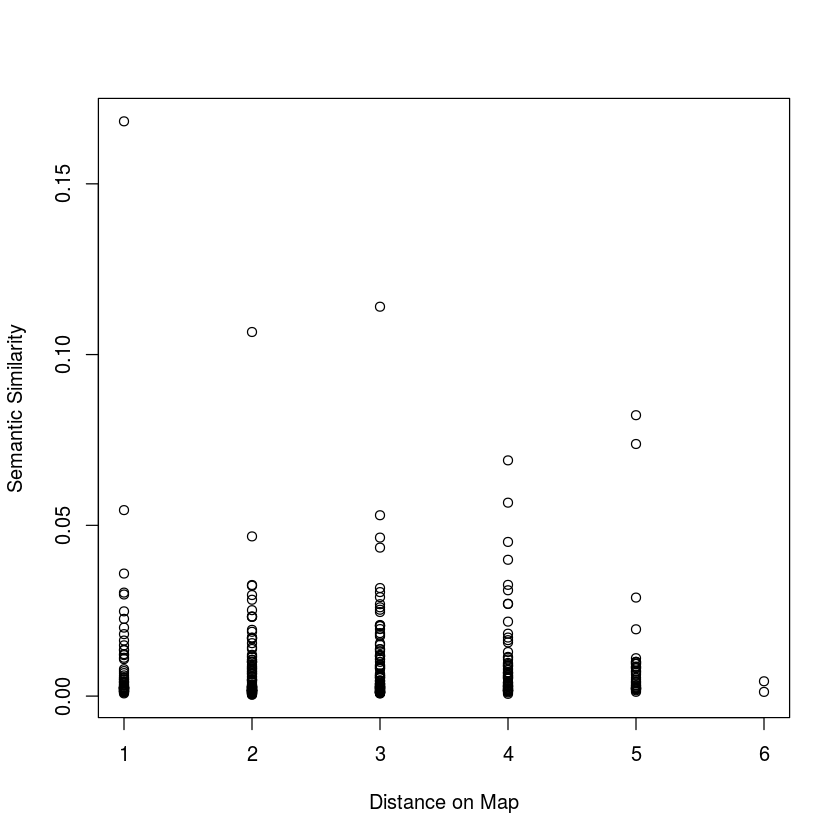

In [51]:
plot(distances, semSims, xlab="Distance on Map", ylab="Semantic Similarity")

In [52]:
cor(distances, semSims)

[1] 0.01196482

In [41]:
library(GOSim)

Loading required package: annotate
Loading required package: XML

Attaching package: ‘XML’

The following object is masked from ‘package:graph’:

    addNode



Loading required package: annotate
Loading required package: XML

Attaching package: ‘XML’

The following object is masked from ‘package:graph’:

    addNode


Attaching package: ‘annotate’

The following object is masked from ‘package:Rgraphviz’:

    toFile

initializing GOSim package ...
-> retrieving GO information for all available genes for organism 'human' in GO database
-> filtering GO terms according to evidence levels 'all'
-> loading files with information content for corresponding GO category (human)
finished.
-> loading files with information content for corresponding GO category (human)


filtering out genes not mapping to the currently set GO category ... ===> list of  20 genes reduced to  18 


The "ward" method has been renamed to "ward.D"; note new "ward.D2"
Loading required package: cluster


  median within cluster similarity similarity mad
1                        0.3645397      0.5404666
2                        0.6084859      0.2042396
3                        0.6129671      0.3894517


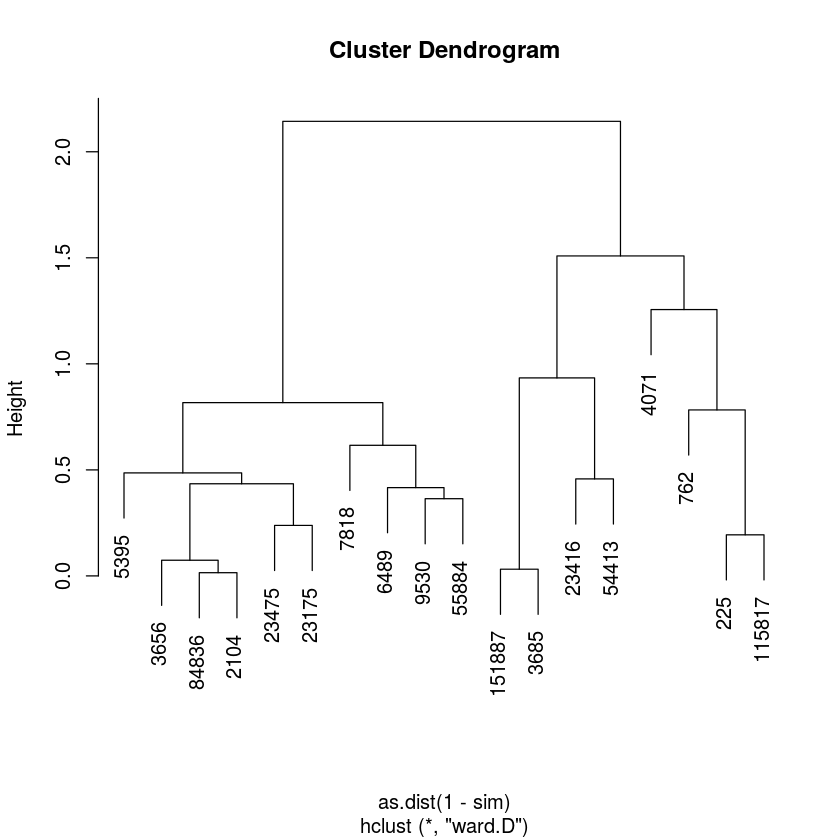


Building most specific GOs .....
	( 3094 GO terms found. )

Build GO DAG topology ..........
	( 6602 GO terms and 15032 relations. )

Annotating nodes ...............
	( 893 genes annotated to the GO terms. )

			 -- Elim Algorithm -- 

		 the algorithm is scoring 156 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 13:	2 nodes to be scored	(0 eliminated genes)

	 Level 12:	5 nodes to be scored	(1 eliminated genes)

	 Level 11:	9 nodes to be scored	(1 eliminated genes)

	 Level 10:	8 nodes to be scored	(2 eliminated genes)

	 Level 9:	6 nodes to be scored	(2 eliminated genes)

	 Level 8:	8 nodes to be scored	(2 eliminated genes)

	 Level 7:	15 nodes to be scored	(2 eliminated genes)

	 Level 6:	26 nodes to be scored	(23 eliminated genes)

	 Level 5:	31 nodes to be scored	(23 eliminated genes)

	 Level 4:	22 nodes to be scored	(23 eliminated genes)

	 Level 3:	16 nodes to be scored	(23 eliminated genes)

	 Level 2:	7 nodes to be scored	(23 eliminate

,go_id,Term,Definition
15362,GO:0006352,"DNA-templated transcription, initiation","Any process involved in the assembly of the RNA polymerase preinitiation complex (PIC) at the core promoter region of a DNA template, resulting in the subsequent synthesis of RNA from that promoter. The initiation phase includes PIC assembly and the formation of the first few bonds in the RNA chain, including abortive initiation, which occurs when the first few nucleotides are repeatedly synthesized and then released. The initiation phase ends just before and does not include promoter clearance, or release, which is the transition between the initiation and elongation phases of transcription."
15393,GO:0006367,transcription initiation from RNA polymerase II promoter,"Any process involved in the assembly of the RNA polymerase II preinitiation complex (PIC) at an RNA polymerase II promoter region of a DNA template, resulting in the subsequent synthesis of RNA from that promoter. The initiation phase includes PIC assembly and the formation of the first few bonds in the RNA chain, including abortive initiation, which occurs when the first few nucleotides are repeatedly synthesized and then released. Promoter clearance, or release, is the transition between the initiation and elongation phases of transcription."
16251,GO:0006730,one-carbon metabolic process,The chemical reactions and pathways involving the transfer of one-carbon units in various oxidation states.
26338,GO:0015701,bicarbonate transport,"The directed movement of bicarbonate into, out of or within a cell, or between cells, by means of some agent such as a transporter or pore."
26349,GO:0015711,organic anion transport,"The directed movement of organic anions into, out of or within a cell, or between cells, by means of some agent such as a transporter or pore. Organic anions are atoms or small molecules with a negative charge which contain carbon in covalent linkage."
26563,GO:0015908,fatty acid transport,"The directed movement of fatty acids into, out of or within a cell, or between cells, by means of some agent such as a transporter or pore. Fatty acids are aliphatic monocarboxylic acids liberated from naturally occurring fats and oils by hydrolysis."
26564,GO:0015909,long-chain fatty acid transport,"The directed movement of long-chain fatty acids into, out of or within a cell, or between cells, by means of some agent such as a transporter or pore. A long-chain fatty acid is a fatty acid with a chain length between C13 and C22."
37800,GO:0032000,positive regulation of fatty acid beta-oxidation,"Any process that activates or increases the frequency, rate or extent of fatty acid beta-oxidation."
50291,GO:0042760,very long-chain fatty acid catabolic process,The chemical reactions and pathways resulting in the breakdown of a fatty acid which has a chain length greater than C22.
51729,GO:0043401,steroid hormone mediated signaling pathway,A series of molecular signals mediated by a steroid hormone binding to a receptor.


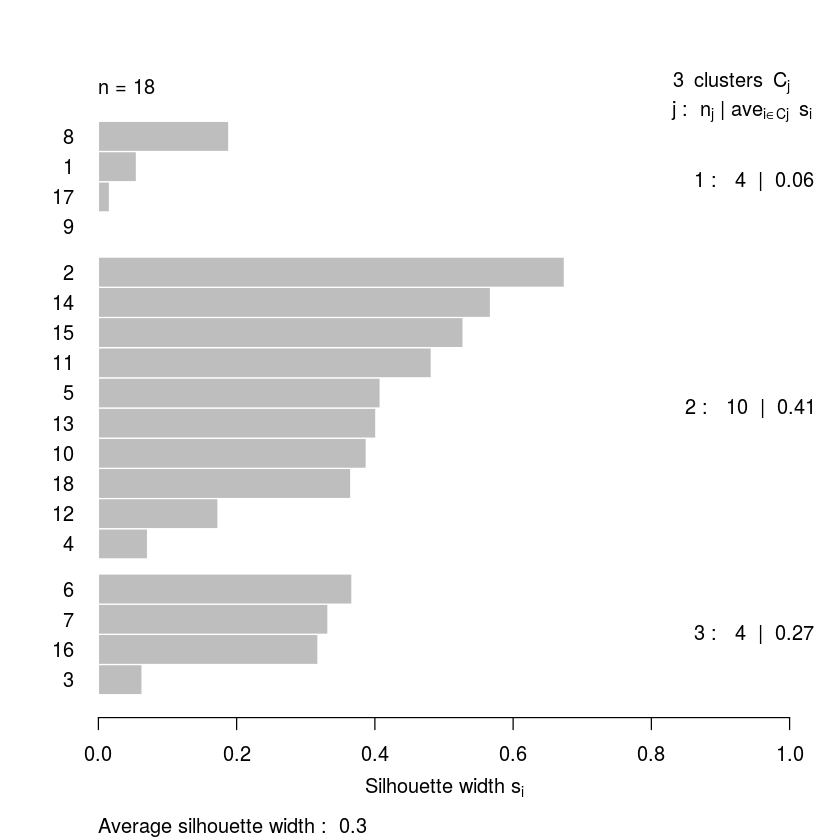

In [147]:

setOntology("BP")
gomap <- get("gomap",env=GOSimEnv)
allgenes = sample(names(gomap), 1000) # suppose these are all genes
genesOfInterest = sample(allgenes, 20) # suppose these are all genes of interest
sim = getGeneSim(genesOfInterest,verbose=FALSE) # and these are their similarities
hc = hclust(as.dist(1-sim), method="ward") # use them to perform a clustering
plot(hc) # plot the cluster tree
cl = cutree(hc, k=3) # take 3 clusters
if(require(cluster)){
    ev = evaluateClustering(cl, sim) # evaluate the clustering
    print(ev$clusterstats) # print out some statistics
    plot(ev$clustersil,main="") # plot the cluster silhouettes
}
# investigate cluster 1 further
if(require(topGO))
    GOenrichment(genesOfInterest[cl == 1], allgenes, cutoff=0.05) # print out what cluster 1 is about

In [52]:
library(clusterProfiler)
david <- enrichDAVID(gene = g[[1]],
                     idType = "ENSEMBL_GENE_ID",
                     listType = "Gene",
                     annotation = "GOTERM_CC_DIRECT",
                     david.user = "dxm237@cs.bham.ac.uk")

In [54]:
david 

ERROR: Error in (function (classes, fdef, mtable) : unable to find an inherited method for function ‘columns’ for signature ‘"enrichResult"’
